# Feature selection (RDKit descriptors):
**Selecting molecular descriptors following the Ash & Fourches (2017) procedure** (it is assumed that these steps were made independently for each set of descriptors):
1. **Low variance filter:** Features in the lower variance quartile were discarde.
    - This means that at least 25% of the features will be removed.
    
    
2. **Correlation filters:** For any pair of descriptors with $|r| > 0.9$ the descriptor with largest mean of $|r|$ was removed.

#### Additionaly they did the following analysis (not necessarily to drop features):
1. **Pearson correlation between each descriptor and pKi values.**  
2. **Paired t-test between active and inactive ligands using each set of descriptors.**

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [2]:
file_ = './main_table_of_Fourches_ligs_ERK2.pkl'
with open(file_, 'rb') as f:
    df_erk2_mols = pickle.load(f)
df_erk2_mols = df_erk2_mols.set_index('Name')

RDKit WARNING: [18:28:00] Enabling RDKit 2019.09.1 jupyter extensions


# MACC Keys

In [84]:
#  Let's extract the MACCS Keys as a Data frame
s = df_erk2_mols.maccs.map(lambda x: list(map(np.int, x)))
df_maccs_all = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
# We have to clarify that MACCS Keys from rdkit includes a dummy key at the begining due to the 0 indexing
# Let's drop it
df_maccs_all = df_maccs_all.drop([0], axis=1)
df_maccs_all.head()

,1,2,3,4,5,6,7,8,9,10,...,157,158,159,160,161,162,163,164,165,166
CSAR_erk2_18,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
CSAR_erk2_20,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
CSAR_erk2_17,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
CSAR_erk2_16,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
CSAR_erk2_15,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


#### Using t-SNE to start the EDA

In [85]:
from sklearn.manifold import TSNE

In [140]:
tsne = TSNE(learning_rate=50)
tsne_bits = tsne.fit_transform(df_maccs_all)

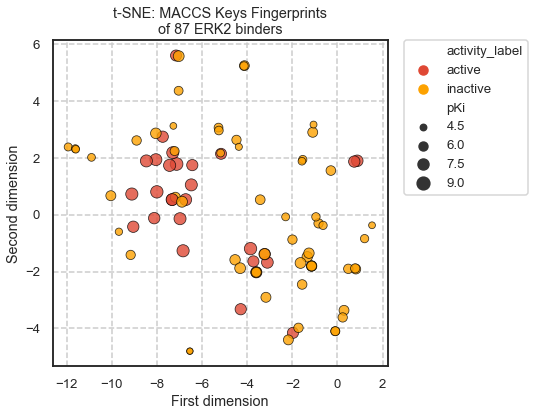

In [151]:
# Create the dataframe to plot the values
df_tsne = df_erk2_mols[['pKi', 'activity_label']].copy()
df_tsne['tsne_x'] = tsne_bits[:, 0]
df_tsne['tsne_y'] = tsne_bits[:, 1]

# plot the figura
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='activity_label', size='pKi', data=df_tsne, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.set(title='t-SNE: MACCS Keys Fingerprints\nof 87 ERK2 binders',
      xlabel='First dimension', ylabel='Second dimension')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

### Variance Threshold

Ash and Fourches dropped all the features/bits inside the lower quartile of the feature variances. This meas they would remove 166/4 ~ 42 variables; however, they actually remove 45 variables (see Table 1). 

##### In our results, how many bits have only 0 or 1 values?

In [4]:
n_ones = (df_maccs_all.sum().values == 87).sum()
n_zeros = (df_maccs_all.sum().values == 0).sum()
print('Features/bits with only 1 values:', n_ones)
# How many bits have only zeros
print('Features/bits with only 0 values:', n_zeros)
# Number of constant features
print('# of constant features:', n_ones + n_zeros)

Features/bits with only 1 values: 9
Features/bits with only 0 values: 37
# of constant features: 46


 We can start by droping these 42 features with only zeros, then we'll have 129 remained bits

##### Use the VarianceThreshold class from *sklearn*:

In [5]:
from sklearn.feature_selection import VarianceThreshold

In [6]:
sel_var = VarianceThreshold(0)
df_maccs_flt1 = sel_var.fit_transform(df_maccs_all)
df_maccs_flt1.shape

(87, 120)

##### Boolean features (Bernoulli rvs)
Assuming each descriptor is a Bernoulli random variable with $p = n_a/N$:
> $var(x) = p(1 - p)$

In [7]:
n = 87
p = df_maccs_all.sum()/n
var = p*(1-p)
# As expected the result is the  same as the given by sklearn
q = np.percentile(var.values, 0.25)
df_maccs_flt_var = df_maccs_all.loc[:, var.values > q]
df_maccs_flt_var.shape

(87, 120)

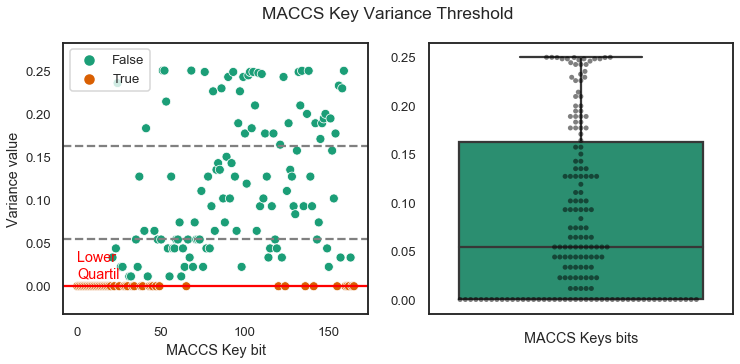

46 features were dropped.


In [36]:
# Plot variances
sns.set(style='white', palette='Dark2', context='talk', font_scale=0.8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('MACCS Key Variance Threshold')
q1, q2, q3 = np.quantile(var.values, [0.25, 0.5, 0.75])

ax1 = sns.scatterplot(x=range(0,166), y=var, ax=ax1, hue=(var <= q1))
ax1.set(xlabel='MACCS Key bit', ylabel='Variance value')
ax1.annotate('Lower\nQuartil', xy=(0, q1+0.01), color='red')
ax1.axhline(q1, color='red')
ax1.axhline(q2, color='grey', linestyle='--')
ax1.axhline(q3, color='grey', linestyle='--')

ax2 = sns.boxplot(y=var, ax=ax2)
ax2 = sns.swarmplot(y=var, ax=ax2, color='black', alpha=0.5)
ax2.set(xlabel='MACCS Keys bits')
plt.show()

print(sum(var <= q1), 'features were dropped.')

#### Visualizing the remained features

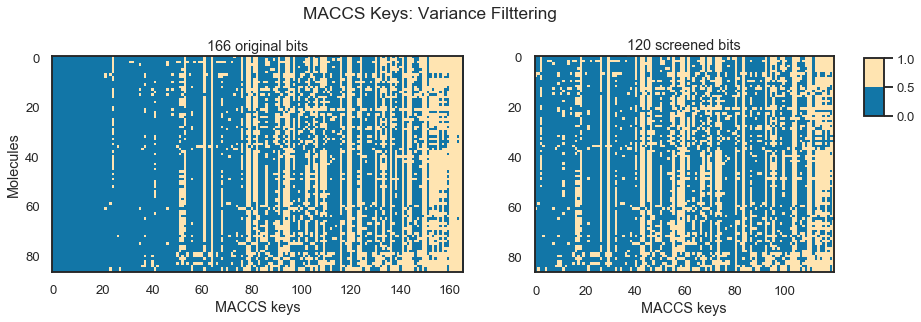

In [156]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

# colormap
cmap_heatmap = ListedColormap(['#1276a7', '#FFE4B1'])

gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[1.1, 0.8])
fig = plt.figure(figsize=(14, 4))
fig.suptitle('MACCS Keys: Variance Filttering', y = 1.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xlab = 'MACCS keys'
s = ax1.imshow(df_maccs_all, cmap=cmap_heatmap)
ax1.set(title='166 original bits', xlabel=xlab, ylabel='Molecules')
ax2.imshow(df_maccs_flt_var, cmap=cmap_heatmap)
ax2.set(title='120 screened bits', xlabel=xlab)
fig.colorbar(s, ax=ax1, cax=fig.add_axes([0.93, 0.67, 0.02, 0.2]))
plt.show()

### Correlation Filtering 

#### Matthews correlation coefficient (phi corr. coef.)

In [10]:
from sklearn.metrics import matthews_corrcoef
from correlation_filter import *

0.03571428571428571


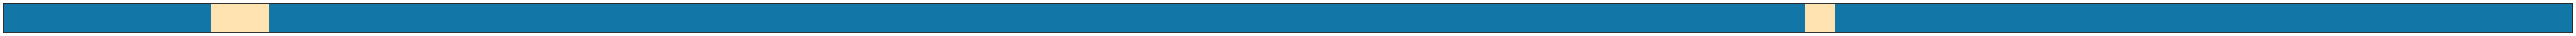

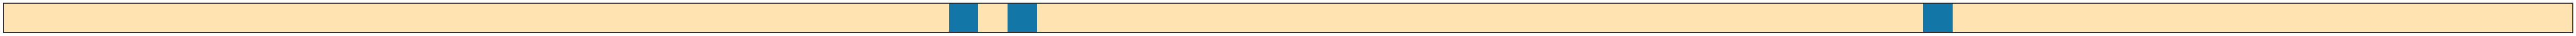

In [11]:
print(matthews_corrcoef(df_maccs_flt_var[ 22 ],
                  df_maccs_flt_var[ 164 ]))

bit_92_palette = ['#FFE4B1' if i else '#1276a7' for i in df_maccs_flt_var[22].values]
sns.palplot(sns.color_palette(bit_92_palette))

bit_110_palette = ['#FFE4B1' if i else '#1276a7' for i in df_maccs_flt_var[164].values]
sns.palplot(sns.color_palette(bit_110_palette))

Compute **phi correlation** for all the features.

In [12]:
from sklearn.metrics import matthews_corrcoef
def get_phi_correlation_matrix(df, return_df=True):
    '''Computes Matthews Correalation coefficient given a tidy DataFrame'''
    n_features = len(df.columns)
    # Create the empty matrix
    phi_corr_mtx = np.zeros((n_features, n_features))
    for idx_i, f_i in enumerate(df.columns):
        for idx_j, f_j in enumerate(df.columns):
            phi = matthews_corrcoef(df[f_i], df[f_j])
            # Add value to the matrix
            phi_corr_mtx[idx_i, idx_j] = phi
    if return_df:
        phi_corr_mtx = pd.DataFrame(phi_corr_mtx, columns=df.columns, index=df.columns)
    return phi_corr_mtx

Get the Matthews correlation coefficient:

In [13]:
df_macc_phi_corr = get_phi_correlation_matrix(df_maccs_flt_var, return_df=True)

In [14]:
#features_to_drop(df_tan, max_thr = 1, min_thr = 0.99, step =  0.01, verbose = False)
features_to_drop_mcc = features_to_drop(dataset=df_maccs_flt_var, correlated_mtx = df_macc_phi_corr, 
                         max_thr = 1, min_thr = 0.9, step =  0.01, verbose = False, absoluted=True)
len(features_to_drop_mcc)

23

In [15]:
df_maccs_flt_phi = df_maccs_flt_var.drop(features_to_drop_mcc, axis=1)
df_maccs_flt_phi.shape

(87, 97)

### Visualization before and after correlation

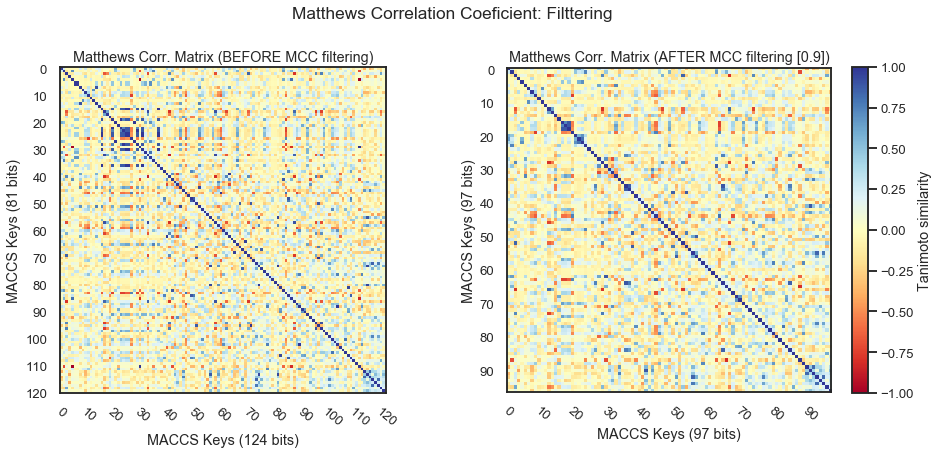

In [158]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Matthews Correlation Coeficient: Filttering', y = 1.02)

plt.subplot(1, 2, 1)
plt.imshow(df_macc_phi_corr, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, 125, 10))
plt.xticks(range(0, 125, 10), rotation=-40)
plt.xlabel('MACCS Keys (124 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Matthews Corr. Matrix (BEFORE MCC filtering)')

plt.subplot(1, 2, 2)
df_macc_phi_corr_filtered = df_macc_phi_corr.drop(features_to_drop_mcc, axis=1).drop(features_to_drop_mcc, axis=0)
n_new_feat = len(df_macc_phi_corr_filtered)
plt.imshow(df_macc_phi_corr_filtered, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_new_feat, 10))
plt.xticks(range(0, n_new_feat, 10), rotation=-40)
plt.xlabel(f'MACCS Keys ({n_new_feat} bits)')
plt.ylabel(F'MACCS Keys ({n_new_feat} bits)')
plt.title('Matthews Corr. Matrix (AFTER MCC filtering [0.9])')

cbar = plt.colorbar()
cbar.set_label('Tanimoto similarity')
plt.show()

### Tanimoto similarity

In [17]:
from scipy.spatial.distance import pdist, squareform
from correlation_filter import *

In [18]:
# Better than correlation, we should use a similarity metric to compare the binary vectors
# From this perspective we're not comparing similarity between observations, but between features
# We substract the value (distance) from 1 to get similarity
cm_jaccard = pdist(df_maccs_flt_var.T, 'jaccard') 
# Convert to a matrix and plot it
mtx_tan = 1 - squareform(cm_jaccard)
# Let's force the diagonal to have values above 1 to distinguish between these values
np.fill_diagonal(mtx_tan, 1.1)
# convert to  a DataFrame
df_tan = pd.DataFrame(mtx_tan, index=df_maccs_flt_var.columns, columns=df_maccs_flt_var.columns)

As an example let's visualize features with similar behavior inside the dataset

Features 83 and 120 have a Tanimoto coef. of: 0.9759036144578314


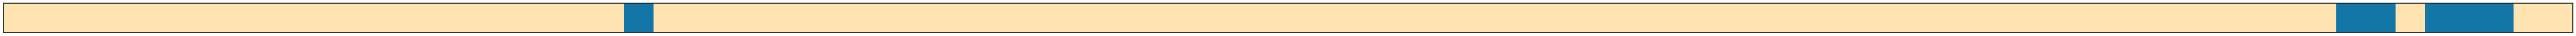

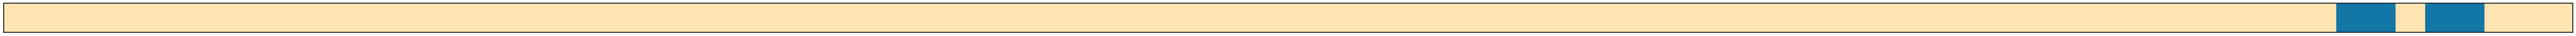

In [19]:
tan_max_idx1_ie = df_tan[df_tan < 0.98].max().idxmax()
tan_max_idx2_ie = df_tan[df_tan < 0.98].loc[: , tan_max_idx1_ie].idxmax()
tan_coef_value_example = df_tan.loc[tan_max_idx1_ie, tan_max_idx2_ie]

# Example
print('Features', tan_max_idx1_ie, 'and', tan_max_idx2_ie, 'have a Tanimoto coef. of:', tan_coef_value_example)
# Plot them
bit_92_palette = ['#FFE4B1' if i else '#1276a7' for i in df_maccs_flt_var.loc[:, tan_max_idx1_ie].values]
sns.palplot(sns.color_palette(bit_92_palette))

bit_110_palette = ['#FFE4B1' if i else '#1276a7' for i in df_maccs_flt_var.loc[:, tan_max_idx2_ie].values]
sns.palplot(sns.color_palette(bit_110_palette))

#### Dropping features (bits)
Adapting the strategy used by Fourches;
1. We're  going to sum all Tanimoto  coefficients per each feature.
2. We'll identify all feature pairs with Tanimoto coefficient higher than 0.95

#### Using Tanimoto coefficient from rdkit

#### Using jaccard through scipy

In [20]:
bits_to_drop = features_to_drop(df_tan, max_thr = 1, min_thr = 0.99, step =  0.01, verbose = False)
# Drop the features:
df_maccs_flt_tan = df_maccs_flt_var.drop(bits_to_drop, axis=1)


# Get the new tanimoto matrix just to plot and compare
_cm_jaccard = pdist(df_maccs_flt_tan.T, 'jaccard') 
_mtx_tan = 1 - squareform(_cm_jaccard)
np.fill_diagonal(_mtx_tan, 1.1)
_df_tan = pd.DataFrame(_mtx_tan, index=df_maccs_flt_tan.columns, columns=df_maccs_flt_tan.columns)

#### Visualization before and after feature selection

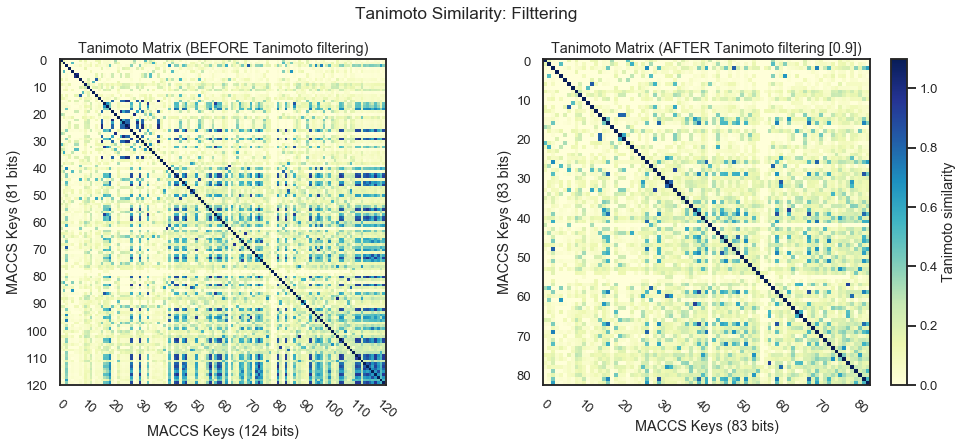

In [160]:
fig = plt.figure(figsize=(17, 6))
plt.suptitle('Tanimoto Similarity: Filttering', y=1.)

plt.subplot(1, 2, 1)
plt.imshow(df_tan, cmap='YlGnBu')
plt.yticks(range(0, 125, 10))
plt.xticks(range(0, 125, 10), rotation=-40)
plt.xlabel('MACCS Keys (124 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Tanimoto Matrix (BEFORE Tanimoto filtering)')

plt.subplot(1, 2, 2)
plt.imshow(_df_tan, cmap='YlGnBu')
n_tan_feat = df_maccs_flt_tan.shape[1]
plt.yticks(range(0, n_tan_feat, 10))
plt.xticks(range(0, n_tan_feat, 10), rotation=-40)
plt.xlabel(f'MACCS Keys ({n_tan_feat} bits)'); plt.ylabel(f'MACCS Keys ({n_tan_feat} bits)')
plt.title('Tanimoto Matrix (AFTER Tanimoto filtering [0.9])')

cbar = plt.colorbar()
cbar.set_label('Tanimoto similarity')
plt.show()

Which features are the same between those filter with MCC and Tanimoto coefficients:

In [22]:
len(set(df_maccs_flt_phi.columns.tolist()) & set(df_maccs_flt_tan.columns.tolist()))

73

### Clustering: *97 bits/features remaining after MCC filtering*

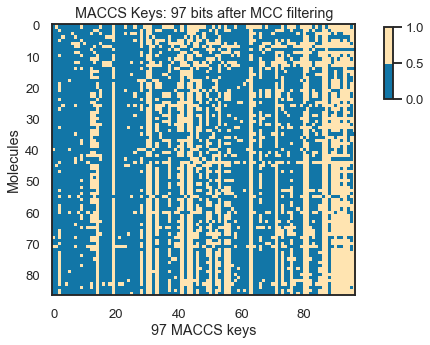

In [23]:
df_maccs_flt_phi['pKi'] = df_erk2_mols['pKi']
df_maccs_flt_phi = df_maccs_flt_phi.sort_values('pKi', ascending=True)

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(df_maccs_flt_phi.drop('pKi', axis=1), cmap=cmap_heatmap)
ax.set(title='MACCS Keys: 97 bits after MCC filtering', xlabel='97 MACCS keys', ylabel='Molecules')
fig.colorbar(s, ax=ax1, cax=fig.add_axes([0.93, 0.67, 0.02, 0.2]))
plt.show()

### Clustermap

In [24]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


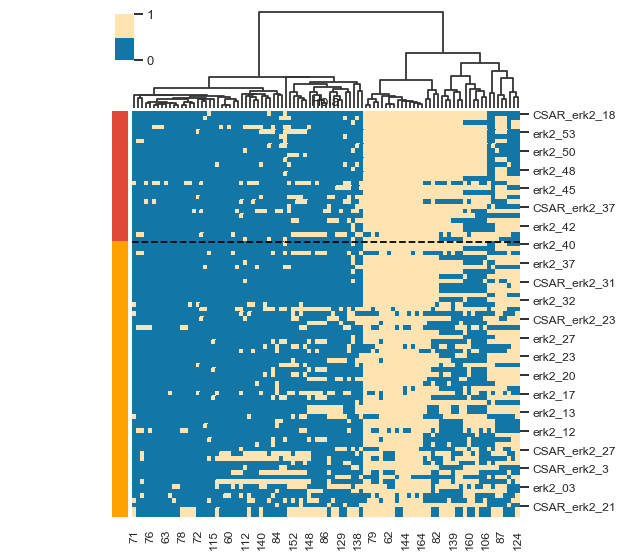

In [25]:
df = df_maccs_flt_phi.sort_values('pKi',ascending=False)
df_maccs = df.drop('pKi', axis=1)

# Tanimoto distances (Jaccard distances)
dist_tan_col = pdist(df_maccs.T, 'rogerstanimoto')
link_tan_col = linkage(squareform(dist_tan_col), method='average')

# Row coloring to identify Active and Inactive Molecules
colors_rows = ['#df4834' if i >= 7.5 else '#fda200' for i in df['pKi']]

clusmap = sns.clustermap(df_maccs, cmap =['#1276a7', '#FFE4B1'],
                standard_scale=1,
                row_cluster=False,
                col_linkage=link_tan_col,
                row_colors=colors_rows,
                cbar_pos=(0.19, .88, .03, .08),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 8)
              )

# Number of actives
n_actives = sum(df['pKi'] >= 7.5)
ax = clusmap.ax_heatmap
ax.set_xticklabels(clusmap.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
ax.hlines(y=n_actives, xmin=0, xmax=97, linewidth=1.8, linestyle='--', color = 'k')
ax.set_title('Hola')
plt.show()

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


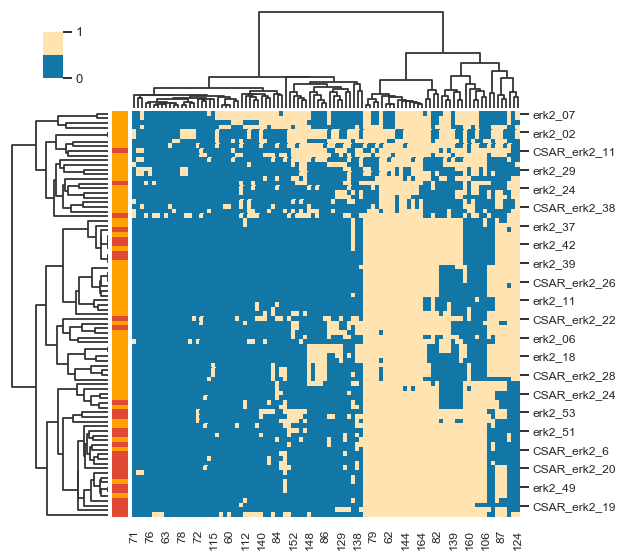

In [28]:
dist_tan_rows = pdist(df_maccs, 'rogerstanimoto')
link_tan_rows = linkage(squareform(dist_tan_rows), method='average', optimal_ordering=True)

clusmap = sns.clustermap(df_maccs, cmap =['#1276a7', '#FFE4B1'],
                standard_scale=1,
                row_linkage=link_tan_rows,
                col_linkage=link_tan_col,
                col_cluster=True,
                row_colors=colors_rows,
                cbar_pos=(0.08, .85, .03, .08),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 8)
              )

ax = clusmap.ax_heatmap
ax.set_xticklabels(clusmap.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
plt.show()

### Clustermap using R
###### fastcluster and heatmap functions

In [31]:
%load_ext rpy2.ipython
# needed to run R inside the notebook

In [32]:
# Preparing the data to parse it to R
df = df_maccs_flt_phi.sort_values('pKi',ascending=False)
df_maccs = df.drop('pKi', axis=1)
colors_rows = ['#df4834' if i >= 7.5 else '#fda200' for i in df['pKi']]
dist_tan_col_from_python = squareform(dist_tan_col)

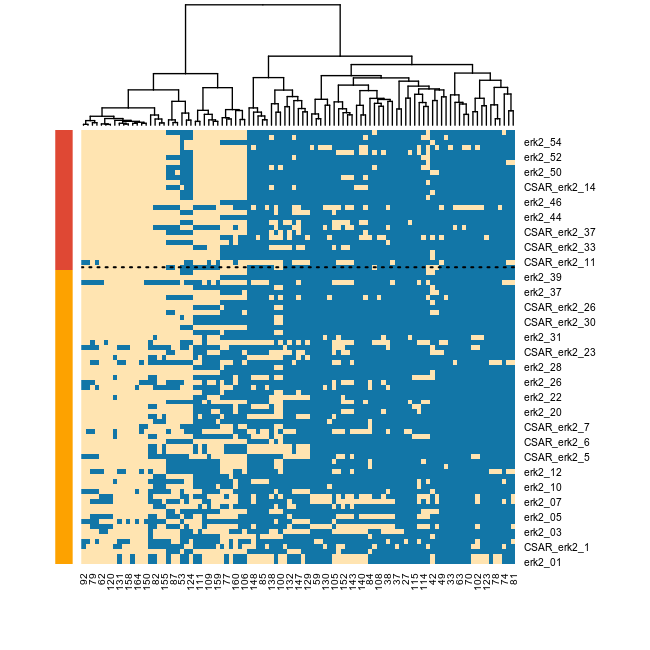

In [33]:
%%R -i df_maccs -i dist_tan_col_from_python -i colors_rows -w 5 -h 5 --units in -r 130

# Invert the order of rows (molecules) in the data frame
df_maccs <- df_maccs[rev(rownames(df_maccs)), ]

# Parse the distance matrix and perform the clustering using fastcluster
#dist_matx <- as.dist(dist_tan_col_from_python)
dist_matx <- vegan::vegdist(t(df_maccs), method = 'jaccard')

clust <- fastcluster::hclust(dist_matx, method='ward.D2')
# ward.D gives the most similar result (average)
dendogram <- as.dendrogram(clust)

# List of colors to identify actives/inactives
activity_colors <- rev(unlist(colors_rows))

heatmap(as.matrix(df_maccs),
        scale='row',
        Colv = dendogram,
        Rowv = NA,
        col=c('#1276a7', '#FFE4B1'),
        RowSideColors = activity_colors,
        add.expr = abline(h = c(87 - 27), lwd = 1.5, lty=3)
       )

## Logistic Regression to compare Actives against Inactives 

In [66]:
%%R

mCars <- read.csv('https://gist.githubusercontent.com/seankross/a412dfbd88b3db70b74b/raw/5f23f993cd87c283ce766e7ac6b329ee7cc2e1d1/mtcars.csv')

am.lg <- glm(formula = am ~ wt,
            data = mCars,
            family = binomial)
summary(am.lg)


Call:
glm(formula = am ~ wt, family = binomial, data = mCars)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2,11400  -0,53738  -0,08811   0,26055   2,19931  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   12,040      4,510   2,670  0,00759 **
wt            -4,024      1,436  -2,801  0,00509 **
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘.’ 0,1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43,230  on 31  degrees of freedom
Residual deviance: 19,176  on 30  degrees of freedom
AIC: 23,176

Number of Fisher Scoring iterations: 6



In [59]:
# With python
from sklearn.linear_model import LogisticRegression

m_cars = pd.read_csv('https://gist.githubusercontent.com/seankross/a412dfbd88b3db70b74b/raw/5f23f993cd87c283ce766e7ac6b329ee7cc2e1d1/mtcars.csv')

X = m_cars[['hp', 'wt']]
y = m_cars[['am']]

lg = LogisticRegression(C=1000000)

lg.fit(X, y)

lg.coef_
#lg.intercept_

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 0.03625526, -8.08339894]])

In [58]:
X = m_cars[['wt']]
lg.fit(X, y)

lg.coef_
#lg.intercept_

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[-4.0237859]])

#### Recursive Feature Elimination and Logistic Regression to drop features

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [ ]:
# Define the sets
y = df_erk2_mols.activity
X = df_maccs_all

In [ ]:
# We'll use a Logistic Regression Clasifier to perform Feature Selection
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
ref_lg = RFE(estimator = lg, n_features_to_select = 97, step = 1)
ref_lg.fit(X, y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
ref_tree = RFE(estimator = tree, n_features_to_select = 97, step = 1)
ref_tree.fit(X, y)

## RDKit 2D Descriptors

In [ ]:
### KNIME

In [ ]:
rdk2d_knime = pd.read_csv('knime/2d_rdki_knime.csv')
rdk2d_knime['Filename'] = rdk2d_knime['Filename'].apply(lambda x: x.split('.')[0])
rdk2d_knime = rdk2d_knime.set_index('Filename')
rdk2d_knime = rdk2d_knime.iloc[:, 6:]

rdk2d_knime = rdk2d_knime.reindex(df_rdkit_all.index)

In [ ]:
### RDKit

In [ ]:
from rdkit.Chem import Descriptors
# MQN Descriptors go from 1 to 42
names_MQN = ['MQN' + str(i) for i in range(1, 43)]

# Final Lsit of descirptors
names_of_all_rdkit_descriptors = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
FINAL_names_of_all_rdkit_descriptors = names_of_all_rdkit_descriptors + ['CalcNumAtomStereoCenters',
                                                                        'CalcNumUnspecifiedAtomStereoCenters',
                                                                        'GetNumAtoms'] + names_MQN

In [ ]:
s = df_erk2_mols['2d_rdkit'].map(lambda x: x)
df_rdkit_all = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
df_rdkit_all.columns = FINAL_names_of_all_rdkit_descriptors
df_rdkit_all

In [ ]:
df_rdkit_all.columns

In [ ]:
rdk2d_knime.columns